# Best Neighborhood in Pittsburgh: Economic Advantage

**Goal:** Rank Pittsburgh neighborhoods by an **economic strength** lens.

**Metric:** **Economic Advantage Score (EAS)**  
I compared each neighborhood’s **aggregate household income** to a **single U.S. average household income constant**.  
A higher EAS means stronger total earning power relative to the national baseline.

- Neighborhood-level **aggregate income** data.  
- Economic strength is a meaningful part of “bestness.”  
- EAS is simple, transparent, and reproducible.

**Formula:**
\[
\text{EAS} = \frac{\text{Neighborhood Aggregate Household Income}}{\text{Average U.S. Household Income (constant)}}
\]


In [20]:
import pandas as pd
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", 50)

csv_path = "aggregate-household-income-in-the-past-12-months-in-2014-inflation-adjusted-dollars.csv"
df = pd.read_csv(csv_path)
df.head()


,Neighborhood,Id,Estimate; Aggregate household income in the past 12 months (in 2014 Inflation-adjusted dollars),Margin of Error; Aggregate household income in the past 12 months (in 2014 Inflation-adjusted dollars)
0,Allegheny Center,1,28265700,8176700
1,Allegheny West,2,23755400,15159354
2,Allentown,3,40566300,8358735.28
3,Arlington,4,33111400,6248592.971
4,Arlington Heights,5,2515000,1056475



- `Aggregate_Income`: total (aggregate) household income within a neighborhood (inflation-adjusted).
- `MoE_Aggregate_Income`: the margin of error associated with that estimate (not used in the base EAS, but kept in case you add uncertainty analysis later).


In [21]:
for col in ["Aggregate_Income", "MoE_Aggregate_Income"]:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace(",", "", regex=False)
            .replace({"": None})
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.dtypes


Neighborhood                                                                                              object
Id                                                                                                         int64
Estimate; Aggregate household income in the past 12 months (in 2014 Inflation-adjusted dollars)           object
Margin of Error; Aggregate household income in the past 12 months (in 2014 Inflation-adjusted dollars)    object
dtype: object

In [25]:
US_AVG_INCOME = 74_580

# Compute Economic Advantage Score
df["Economic_Advantage_Score"] = df["Aggregate_Income"] / US_AVG_INCOME

# Quick sanity check: no negative or infinite values
assert (df["Economic_Advantage_Score"].dropna() >= 0).all(), "EAS should not be negative."

df[["Neighborhood", "Aggregate_Income", "Economic_Advantage_Score"]].head(10)


KeyError: 'Aggregate_Income'

- We compare **each neighborhood’s total earning power** to a **single national baseline**.  
- Holding the denominator (U.S. average) constant makes values **comparable and interpretable**:  
  - EAS > 1 → neighborhood’s aggregate income exceeds the U.S. average level (scaled).  
  - EAS < 1 → below the national baseline.

**About the constant:**  
- It’s a **fixed parameter** representing the average U.S. household income for a specific year.  
- You can swap in a different reference (e.g., median income instead of average, or a different year) and the method still works.  
- Be consistent and **document the choice** for transparency.


In [16]:
ranked = df.sort_values("Economic_Advantage_Score", ascending=False).reset_index(drop=True)

top10 = ranked.loc[:9, ["Neighborhood", "Aggregate_Income", "Economic_Advantage_Score"]]
bottom10 = ranked.tail(10)[["Neighborhood", "Aggregate_Income", "Economic_Advantage_Score"]]

top10, bottom10


(          Neighborhood  Aggregate_Income  Economic_Advantage_Score
 0  Squirrel Hill South       639717500.0               8577.601234
 1            Shadyside       597347500.0               8009.486457
 2  Squirrel Hill North       561576600.0               7529.855189
 3            Brookline       361244500.0               4843.718155
 4         Point Breeze       299866100.0               4020.730759
 5     Mount Washington       263764100.0               3536.659962
 6           Bloomfield       243725500.0               3267.973988
 7     South Side Flats       240068000.0               3218.932690
 8           Greenfield       235978800.0               3164.102977
 9              Carrick       221566800.0               2970.860821,
             Neighborhood  Aggregate_Income  Economic_Advantage_Score
 81             Ridgemont         7989900.0                107.131939
 82  California-Kirkbride         7593600.0                101.818182
 83                  Hays         6297300

- Top performers support your **key claims** (“best by economic strength”).
- Bottom performers reveal **contrast and distribution** (are outcomes skewed? is there a long tail?).  
- Together, they make your narrative stronger and more honest.


In [17]:
output_csv = "pittsburgh_economic_advantage_ranked.csv"
ranked.to_csv(output_csv, index=False)
output_csv


'pittsburgh_economic_advantage_ranked.csv'

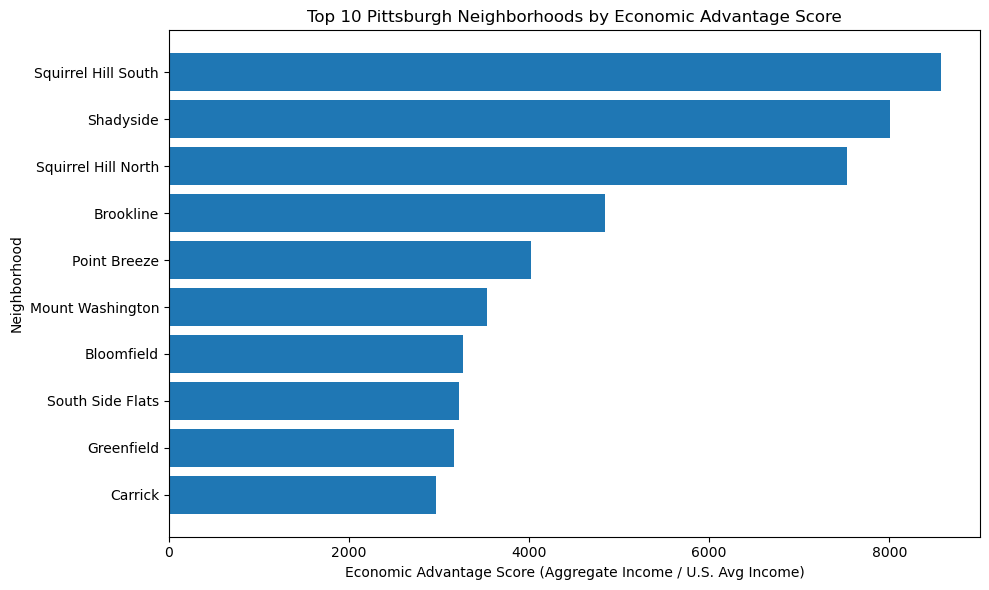

In [18]:
plt.figure(figsize=(10, 6))
plt.barh(top10["Neighborhood"], top10["Economic_Advantage_Score"])
plt.xlabel("Economic Advantage Score (Aggregate Income / U.S. Avg Income)")
plt.ylabel("Neighborhood")
plt.title("Top 10 Pittsburgh Neighborhoods by Economic Advantage Score")
plt.gca().invert_yaxis()  # highest at the top
plt.tight_layout()
plt.show()


- Neighborhood names are textual; horizontal bars **read better** and avoid label overlap.
- Inverting the y-axis places the **best** at the **top**, matching how people read rankings.
- This figure can go directly into your presentation to visually support your claim.


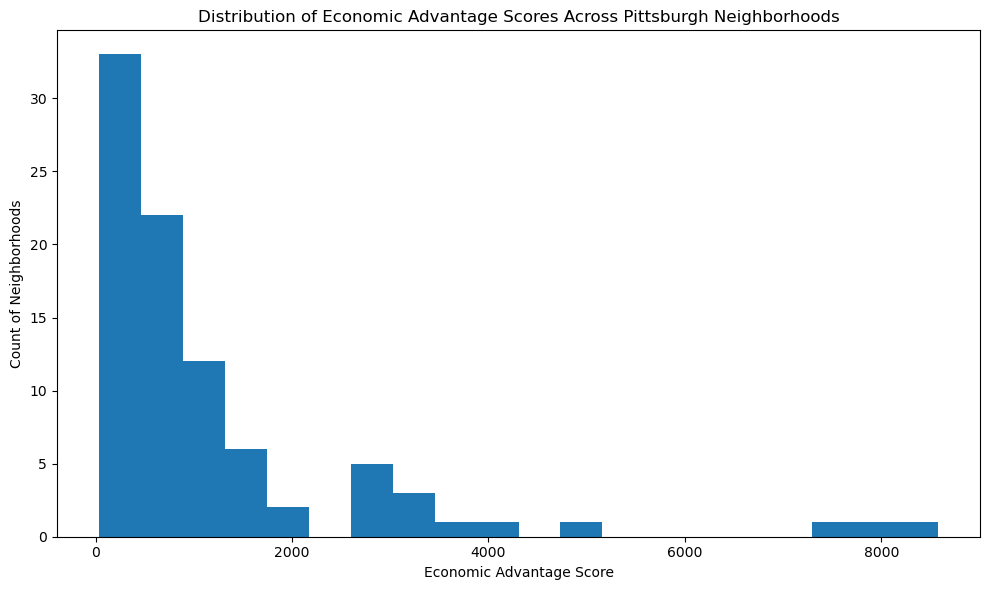

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(ranked["Economic_Advantage_Score"].dropna(), bins=20)
plt.xlabel("Economic Advantage Score")
plt.ylabel("Count of Neighborhoods")
plt.title("Distribution of Economic Advantage Scores Across Pittsburgh Neighborhoods")
plt.tight_layout()
plt.show()


- A histogram shows whether most neighborhoods cluster near the national baseline or if there are **outliers**.
- It supports statements like “Most neighborhoods cluster between X and Y” or “A few neighborhoods have **very** high scores,” which adds nuance to your conclusion.


## Results & Interpretation

**How to read EAS:**  
- **Higher EAS** → stronger total earning power relative to the U.S. baseline.  
- **Lower EAS** → lower total earning power relative to the U.S. baseline.

**What this tells us:**  
- Top-ranked neighborhoods likely have **more aggregate resources**, which can correlate with economic opportunity, investment, and amenities.

**Caveats / Scope limits:**  
- **Aggregate** income is not the same as **median** income and does not adjust for **population**.  
  - A useful extension is to divide `Aggregate_Income` by **number of households** to approximate **income per household** if you can source a households column.  
- This metric is **economic-only**. Your team should combine it with other lenses (safety, parks/green space, transit, etc.) for a well-rounded notion of “best.”

**Reproducibility:**  
- The pipeline is **deterministic**: given the same CSV and U.S. constant, you will get the same rankings.
- If you update the **reference year** or **U.S. average**, your results will update consistently.
